### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**: 7.5

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [82]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

In [83]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [84]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [85]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [ 8596  3159  2275   125  2363 12414  2423  8981 11649  8898] (showing first 10 indices)
Max index: 18823, Min index: 0
Fitting new base model with 5647 samples
Predictions from new base model before gamma adjustment: [ 0.5764865  0.5764865 -0.4235135  0.5764865 -0.4235135]
New base model fitted - Gamma: 0.7882911256588108
Predictions from new base model after gamma adjustment: [ 0.45443919  0.45443919 -0.33385193  0.45443919 -0.33385193]
Iteration 0 - Gamma: 0.7882911256588108
Iteration 0 - New model predictions: [ 0.04544392  0.04544392 -0.03338519  0.04544392 -0.03338519]
Iteration 0 - Updated predictions: [0.26292261 0.26292261 0.34175173 0.26292261 0.34175173]
Iteration 0 - Train Error: 0.6432409282783236
Iteration 

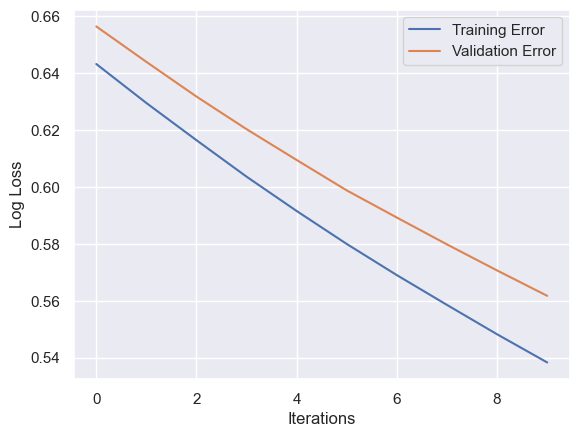

CPU times: total: 1.34 s
Wall time: 1.35 s
Train ROC-AUC 0.9895
Valid ROC-AUC 0.9485
Test ROC-AUC 0.9495


In [87]:
# Создание и обучение модели
boosting = Boosting(n_estimators=10, learning_rate=0.1, subsample=0.3, early_stopping_rounds=5, plot=True)

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators
assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [ 5841  1411 17431 12559 16563   879 15569 15548 18096  3675] (showing first 10 indices)
Max index: 18824, Min index: 1
Fitting new base model with 15060 samples
Predictions from new base model before gamma adjustment: [ 0.27967344  0.27967344  0.27967344 -0.33120229 -0.33120229]
New base model fitted - Gamma: 0.995316950799882
Predictions from new base model after gamma adjustment: [ 0.27836371  0.27836371  0.27836371 -0.32965126 -0.32965126]
Iteration 0 - Gamma: 0.995316950799882
Iteration 0 - New model predictions: [ 0.02783637  0.02783637  0.02783637 -0.03296513 -0.03296513]
Iteration 0 - Updated predictions: [0.28053016 0.28053016 0.28053016 0.34133166 0.34133166]
Iteration 0 - Train Error: 0.6479866529782384
Iterat

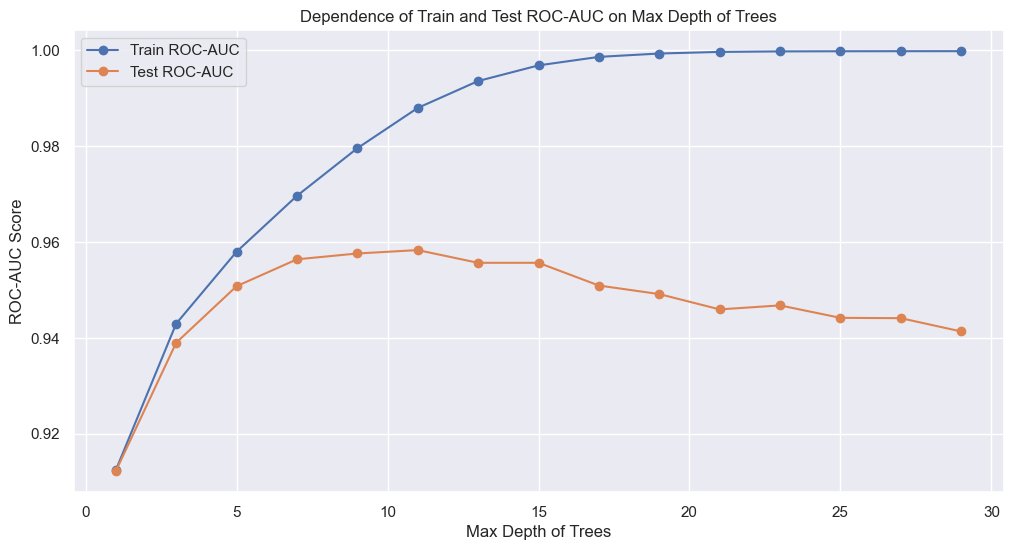

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score


# Инициализация массива для хранения результатов
train_scores = []
test_scores = []

max_depths = range(1, 31, 2)

for max_depth in max_depths:
    # Инициализация и обучение модели
    model = Boosting(
        base_model_params={'max_depth': max_depth},
        n_estimators=50, 
        learning_rate=0.1, 
        subsample=0.8, 
        early_stopping_rounds=None, 
        plot=False
    )
    model.fit(x_train, y_train)

    # Оценка модели на обучающей и тестовой выборке
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

# Построение графика зависимости
plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_scores, label='Train ROC-AUC', marker='o')
plt.plot(max_depths, test_scores, label='Test ROC-AUC', marker='o')
plt.xlabel('Max Depth of Trees')
plt.ylabel('ROC-AUC Score')
plt.title('Dependence of Train and Test ROC-AUC on Max Depth of Trees')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
best_depth = max_depths[np.argmax(test_scores)]
best_score = max(test_scores)

print(f'Best max_depth: {best_depth}')
print(f'Best ROC-AUC: {best_score:.2f}')

Best max_depth: 11
Best ROC-AUC: 0.96


**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Лучшая глубина модели на валидационной выборке находится в диапазоне 7-9. Дальнейшее увеличение глубины приводит к переобучению на тестовых данных, и снижению обобщающей способности на валидационных.

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

[I 2024-05-26 21:38:39,761] A new study created in memory with name: no-name-d757983d-3bb7-4a56-ac57-0c3edf89d3c9


x_train.shape: (18825, 169), y_train.shape: (18825,)
x_valid.shape: (2354, 169), y_valid.shape: (2354,)
Training with max_depth=5, learning_rate=0.16232474404055483, subsample=0.650907480064723, n_estimators=183
Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [15975 11743  8545  5393  2919 12792  5334 18323  9745 17784] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 12253 samples
Predictions from new base model before gamma adjustment: [ 0.4939811   0.21838843 -0.15171863  0.22560931 -0.26652141]
New base model fitted - Gamma: 0.993773122099558
Predictions from new base model after gamma adjustment: [ 0.49090514  0.21702855 -0.15077389  0.22420447 -0.26486182]
Iteration 0 - Gamma: 0.993773122099558
Iteration 0 - New model predict

[I 2024-05-26 21:38:44,054] Trial 0 finished with value: 0.9634390644719735 and parameters: {'max_depth': 5, 'learning_rate': 0.16232474404055483, 'subsample': 0.650907480064723, 'n_estimators': 183}. Best is trial 0 with value: 0.9634390644719735.


Predictions from new base model before gamma adjustment: [ 0.0287508   0.04208166 -0.02222034 -0.20501455  0.04208166]
New base model fitted - Gamma: 0.7355970571074866
Predictions from new base model after gamma adjustment: [ 0.021149    0.03095514 -0.01634522 -0.1508081   0.03095514]
Iteration 178 - Gamma: 0.7355970571074866
Iteration 178 - New model predictions: [ 0.00343301  0.00502479 -0.00265323 -0.02447989  0.00502479]
Iteration 178 - Updated predictions: [-2.16870048 -0.79544185  1.53026746  0.36347201  1.93187548]
Iteration 178 - Train Error: 0.23177829493278643
Iteration 179 - Residuals: [ 0.10259662 -0.6889986  -0.17795456  0.58988065 -0.12654314]
Iteration 179 - Predictions before update: [-2.16870048 -0.79544185  1.53026746  0.36347201  1.93187548]
Number of samples: 18825
Generated indices: [14673 15362  6202 13572 12558 17609 18010  9566  2993 18211] (showing first 10 indices)
Max index: 18823, Min index: 1
Fitting new base model with 12253 samples
Predictions from new b

[I 2024-05-26 21:38:47,698] Trial 1 finished with value: 0.9556482085187344 and parameters: {'max_depth': 3, 'learning_rate': 0.12195656634470445, 'subsample': 0.9145640044992985, 'n_estimators': 199}. Best is trial 0 with value: 0.9634390644719735.


Predictions from new base model before gamma adjustment: [-0.03915557  0.03552261 -0.03915557  0.03552261  0.03552261]
New base model fitted - Gamma: 0.9703002141419155
Predictions from new base model after gamma adjustment: [-0.03799266  0.03446759 -0.03799266  0.03446759  0.03446759]
Iteration 196 - Gamma: 0.9703002141419155
Iteration 196 - New model predictions: [-0.00463345  0.00420355 -0.00463345  0.00420355  0.00420355]
Iteration 196 - Updated predictions: [-1.89035356 -0.54537306  1.38101006  0.63395962  1.57795139]
Iteration 196 - Train Error: 0.27479029675677474
Iteration 197 - Residuals: [ 0.13120416 -0.63306144 -0.20084683  0.65338675 -0.17108581]
Iteration 197 - Predictions before update: [-1.89035356 -0.54537306  1.38101006  0.63395962  1.57795139]
Number of samples: 18825
Generated indices: [ 8401 12238 15291 15507 17317  2284 14615  9514  9303 11282] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 17216 samples
Predictions from new b

[I 2024-05-26 21:38:50,020] Trial 2 finished with value: 0.959672321166436 and parameters: {'max_depth': 3, 'learning_rate': 0.24403763735202408, 'subsample': 0.6553107702763117, 'n_estimators': 169}. Best is trial 0 with value: 0.9634390644719735.


Predictions from new base model before gamma adjustment: [ 0.01881915 -0.03463981 -0.02871214  0.06698266  0.01881915]
New base model fitted - Gamma: 0.8130343967422398
Predictions from new base model after gamma adjustment: [ 0.01530062 -0.02816336 -0.02334396  0.05445921  0.01530062]
Iteration 167 - Gamma: 0.8130343967422398
Iteration 167 - New model predictions: [ 0.00373393 -0.00687292 -0.00569681  0.0132901   0.00373393]
Iteration 167 - Updated predictions: [-2.03570761 -0.43690025  1.69579492  0.69382212  1.89710792]
Iteration 167 - Train Error: 0.2533750741558295
Iteration 168 - Residuals: [ 0.11550453 -0.60752018 -0.15501527  0.66681664 -0.13043615]
Iteration 168 - Predictions before update: [-2.03570761 -0.43690025  1.69579492  0.69382212  1.89710792]
Number of samples: 18825
Generated indices: [18624   314  9984 14889  4438  7984  9871  6568  6956 18238] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 12336 samples
Predictions from new ba

[I 2024-05-26 21:38:50,826] Trial 3 finished with value: 0.9418703697348905 and parameters: {'max_depth': 2, 'learning_rate': 0.2469388282069678, 'subsample': 0.8896064632682886, 'n_estimators': 64}. Best is trial 0 with value: 0.9634390644719735.


Iteration 61 - New model predictions: [ 0.01552105 -0.02018978 -0.01165286 -0.02018978 -0.02018978]
Iteration 61 - Updated predictions: [-1.75082031 -0.6378763   0.68676681  0.79193156  1.35185908]
Iteration 61 - Train Error: 0.3242429744109031
Iteration 62 - Residuals: [ 0.14794376 -0.65427324 -0.3347527   0.68824592 -0.2055666 ]
Iteration 62 - Predictions before update: [-1.75082031 -0.6378763   0.68676681  0.79193156  1.35185908]
Number of samples: 18825
Generated indices: [17861 15506  1880 13310 15769 11145 10798 11250  8815 14979] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 16746 samples
Predictions from new base model before gamma adjustment: [ 0.06498397 -0.05093516 -0.05093516  0.09581736 -0.05093516]
New base model fitted - Gamma: 1.00762708429224
Predictions from new base model after gamma adjustment: [ 0.06547961 -0.05132364 -0.05132364  0.09654816 -0.05132364]
Iteration 62 - Gamma: 1.00762708429224
Iteration 62 - New model predicti

[I 2024-05-26 21:39:04,145] Trial 4 finished with value: 0.964737731108137 and parameters: {'max_depth': 9, 'learning_rate': 0.25866550058860366, 'subsample': 0.8142884517773188, 'n_estimators': 199}. Best is trial 4 with value: 0.964737731108137.


Predictions from new base model before gamma adjustment: [-0.00790361 -0.30406827 -0.20946583 -0.02420882 -0.04840063]
New base model fitted - Gamma: 0.6626616435481781
Predictions from new base model after gamma adjustment: [-0.00523742 -0.20149438 -0.13880497 -0.01604226 -0.03207324]
Iteration 198 - Gamma: 0.6626616435481781
Iteration 198 - New model predictions: [-0.00135474 -0.05211964 -0.03590406 -0.00414958 -0.00829624]
Iteration 198 - Updated predictions: [-2.54386551  0.95668813  1.95413208 -1.23152819  3.09696121]
Iteration 198 - Train Error: 0.125515757773393
roc_auc valid: 0.964737731108137
Training with max_depth=8, learning_rate=0.20766008010963408, subsample=0.9520142907657714, n_estimators=189
Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [10436  3078

[I 2024-05-26 21:39:16,334] Trial 5 finished with value: 0.9646523226153301 and parameters: {'max_depth': 8, 'learning_rate': 0.20766008010963408, 'subsample': 0.9520142907657714, 'n_estimators': 189}. Best is trial 4 with value: 0.964737731108137.


Predictions from new base model before gamma adjustment: [ 0.02524989  0.01076952 -0.00591041 -0.03881192  0.00538248]
New base model fitted - Gamma: 0.9295677555962517
Predictions from new base model after gamma adjustment: [ 0.02347149  0.010011   -0.00549412 -0.03607831  0.00500338]
Iteration 186 - Gamma: 0.9295677555962517
Iteration 186 - New model predictions: [ 0.00487409  0.00207889 -0.00114091 -0.00749202  0.001039  ]
Iteration 186 - Updated predictions: [-2.44812696  0.42282476  1.65239286 -0.84694701  2.76373748]
Iteration 186 - Train Error: 0.15380409799023378
Iteration 187 - Residuals: [ 0.07957563 -0.39584101 -0.16078581  0.30007368 -0.05931548]
Iteration 187 - Predictions before update: [-2.44812696  0.42282476  1.65239286 -0.84694701  2.76373748]
Number of samples: 18825
Generated indices: [ 4397  7816  5375  9136 10170 11202 10509  6505 14364 17769] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 17921 samples
Predictions from new b

[I 2024-05-26 21:39:19,833] Trial 6 finished with value: 0.9628290038090663 and parameters: {'max_depth': 7, 'learning_rate': 0.13057937613609816, 'subsample': 0.659991286054856, 'n_estimators': 88}. Best is trial 4 with value: 0.964737731108137.


Predictions from new base model before gamma adjustment: [ 0.08801866  0.07484808 -0.01306202 -0.05905488 -0.08760188]
New base model fitted - Gamma: 0.881129878272194
Predictions from new base model after gamma adjustment: [ 0.07755588  0.06595088 -0.01150934 -0.05203502 -0.07718863]
Iteration 87 - Gamma: 0.881129878272194
Iteration 87 - New model predictions: [ 0.0101272   0.00861182 -0.00150288 -0.0067947  -0.01007924]
Iteration 87 - Updated predictions: [-1.72332562 -0.81872819  1.34934388  0.21517607  1.78177913]
Iteration 87 - Train Error: 0.2559065343218007
roc_auc valid: 0.9628290038090663
Training with max_depth=1, learning_rate=0.2751434083213733, subsample=0.611790273396291, n_estimators=113
Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [ 2967 16860 15466

[I 2024-05-26 21:39:20,648] Trial 7 finished with value: 0.9363211054299212 and parameters: {'max_depth': 1, 'learning_rate': 0.2751434083213733, 'subsample': 0.611790273396291, 'n_estimators': 113}. Best is trial 4 with value: 0.964737731108137.


roc_auc valid: 0.9363211054299212
Training with max_depth=8, learning_rate=0.10449433253374076, subsample=0.5023654211959134, n_estimators=137
Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [ 9735  2654  5890 17088  9154 13539 16123  5157 14088 11461] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 9457 samples
Predictions from new base model before gamma adjustment: [ 0.48998585  0.48998585 -0.00402197  0.36718418 -0.33462461]
New base model fitted - Gamma: 0.9573549489861811
Predictions from new base model after gamma adjustment: [ 0.46909037  0.46909037 -0.00385046  0.35152559 -0.32035453]
Iteration 0 - Gamma: 0.9573549489861811
Iteration 0 - New model predictions: [ 0.04901729  0.04901729 -0.00040235  0.03673243 -0.03347523]


[I 2024-05-26 21:39:25,877] Trial 8 finished with value: 0.9646565167823875 and parameters: {'max_depth': 8, 'learning_rate': 0.10449433253374076, 'subsample': 0.5023654211959134, 'n_estimators': 137}. Best is trial 4 with value: 0.964737731108137.


Predictions from new base model before gamma adjustment: [ 0.09533293  0.14659666 -0.05509399 -0.04387831 -0.0820632 ]
New base model fitted - Gamma: 0.7275344010764537
Predictions from new base model after gamma adjustment: [ 0.06935798  0.10665411 -0.04008277 -0.03192298 -0.0597038 ]
Iteration 135 - Gamma: 0.7275344010764537
Iteration 135 - New model predictions: [ 0.00724752  0.01114475 -0.00418842 -0.00333577 -0.00623871]
Iteration 135 - Updated predictions: [-1.89306219 -0.60834057  1.35368793  0.05895395  2.03197357]
Iteration 135 - Train Error: 0.2340916524854597
Iteration 136 - Residuals: [ 0.13089571 -0.64756217 -0.20526809  0.51473422 -0.11588656]
Iteration 136 - Predictions before update: [-1.89306219 -0.60834057  1.35368793  0.05895395  2.03197357]
Number of samples: 18825
Generated indices: [ 1822  4670  1870  3165   101   732  7299 13809  4087  8217] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 9457 samples
Predictions from new bas

[I 2024-05-26 21:39:27,821] Trial 9 finished with value: 0.9470208068814844 and parameters: {'max_depth': 3, 'learning_rate': 0.07904881542887768, 'subsample': 0.7338259906638946, 'n_estimators': 127}. Best is trial 4 with value: 0.964737731108137.


Predictions from new base model before gamma adjustment: [ 0.09756514 -0.08688233 -0.08688233 -0.08688233 -0.08688233]
New base model fitted - Gamma: 0.9551294640308249
Predictions from new base model after gamma adjustment: [ 0.09318734 -0.08298387 -0.08298387 -0.08298387 -0.08298387]
Iteration 122 - Gamma: 0.9551294640308249
Iteration 122 - New model predictions: [ 0.00736635 -0.00655978 -0.00655978 -0.00655978 -0.00655978]
Iteration 122 - Updated predictions: [-1.45558789 -0.67970162  0.73096965  0.76191898  1.15569874]
Iteration 122 - Train Error: 0.32961160247287485
Iteration 123 - Residuals: [ 0.18914307 -0.6636721  -0.32498198  0.68177022 -0.23944972]
Iteration 123 - Predictions before update: [-1.45558789 -0.67970162  0.73096965  0.76191898  1.15569874]
Number of samples: 18825
Generated indices: [12938  9587  4253 15099  5672  2637  4519 12851  1366 18564] (showing first 10 indices)
Max index: 18823, Min index: 0
Fitting new base model with 13814 samples
Predictions from new b

[I 2024-05-26 21:39:33,810] Trial 10 finished with value: 0.9545367542485006 and parameters: {'max_depth': 6, 'learning_rate': 0.012106670829227534, 'subsample': 0.8179568818957983, 'n_estimators': 154}. Best is trial 4 with value: 0.964737731108137.


Predictions from new base model before gamma adjustment: [ 0.32378026  0.04773951 -0.14213679  0.24935334 -0.24796934]
New base model fitted - Gamma: 0.9945860243371293
Predictions from new base model after gamma adjustment: [ 0.32202732  0.04748105 -0.14136726  0.24800335 -0.24662684]
Iteration 151 - Gamma: 0.9945860243371293
Iteration 151 - New model predictions: [ 0.00389868  0.00057484 -0.00171149  0.00300249 -0.00298583]
Iteration 151 - Updated predictions: [-0.44911043 -0.13677654  0.47503518 -0.02719141  0.68331379]
Iteration 151 - Train Error: 0.4720234527416286
Iteration 152 - Residuals: [ 0.38957229 -0.53414093 -0.38342518  0.49320257 -0.3355221 ]
Iteration 152 - Predictions before update: [-0.44911043 -0.13677654  0.47503518 -0.02719141  0.68331379]
Number of samples: 18825
Generated indices: [13496 13836 15395 18687  8938  4097 12768 11491 12634 16160] (showing first 10 indices)
Max index: 18823, Min index: 0
Fitting new base model with 15398 samples
Predictions from new ba

[I 2024-05-26 21:39:41,277] Trial 11 finished with value: 0.963680419721736 and parameters: {'max_depth': 9, 'learning_rate': 0.06974184540802, 'subsample': 0.5494732311929726, 'n_estimators': 141}. Best is trial 4 with value: 0.964737731108137.


roc_auc valid: 0.963680419721736
Training with max_depth=9, learning_rate=0.1871525356838224, subsample=0.7791662639448477, n_estimators=111
Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [14509  1871 18040  2218  5087 13350 11008 12511  6110  8413] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 14667 samples
Predictions from new base model before gamma adjustment: [ 0.5324313   0.46537539 -0.11373089 -0.1735135  -0.27107448]
New base model fitted - Gamma: 0.9827360185325619
Predictions from new base model after gamma adjustment: [ 0.52323941  0.45734116 -0.11176744 -0.17051797 -0.26639465]
Iteration 0 - Gamma: 0.9827360185325619
Iteration 0 - New model predictions: [ 0.09792558  0.08559256 -0.02091756 -0.03191287 -0.04985643]
I

[I 2024-05-26 21:39:49,153] Trial 12 finished with value: 0.9640967861241703 and parameters: {'max_depth': 9, 'learning_rate': 0.1871525356838224, 'subsample': 0.7791662639448477, 'n_estimators': 111}. Best is trial 4 with value: 0.964737731108137.


Predictions from new base model before gamma adjustment: [ 0.04305741 -0.11557633 -0.03829703 -0.07079953  0.07634124]
New base model fitted - Gamma: 0.8133220343881369
Predictions from new base model after gamma adjustment: [ 0.03501954 -0.09400078 -0.03114782 -0.05758282  0.06209002]
Iteration 109 - Gamma: 0.8133220343881369
Iteration 109 - New model predictions: [ 0.006554   -0.01759248 -0.00582939 -0.01077677  0.0116203 ]
Iteration 109 - Updated predictions: [-2.09459481 -0.2903594   1.61216089 -0.63940854  2.38839191]
Iteration 109 - Train Error: 0.17937890454335134
Iteration 110 - Residuals: [ 0.10962329 -0.57208412 -0.16628882  0.34538025 -0.08406217]
Iteration 110 - Predictions before update: [-2.09459481 -0.2903594   1.61216089 -0.63940854  2.38839191]
Number of samples: 18825
Generated indices: [ 7099 11459  3483  8114 17982  3105  8894   223  4854 16432] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 14667 samples
Predictions from new b

[I 2024-05-26 21:39:54,041] Trial 13 finished with value: 0.9655300473940878 and parameters: {'max_depth': 7, 'learning_rate': 0.290231675687609, 'subsample': 0.526256269796991, 'n_estimators': 160}. Best is trial 13 with value: 0.9655300473940878.


Predictions from new base model before gamma adjustment: [ 0.04240009 -0.09170934  0.00867341 -0.01296347 -0.06517746]
New base model fitted - Gamma: 0.4239392824047119
Predictions from new base model after gamma adjustment: [ 0.01797506 -0.03887919  0.003677   -0.00549572 -0.02763129]
Iteration 155 - Gamma: 0.4239392824047119
Iteration 155 - New model predictions: [ 0.00521693 -0.01128397  0.00106718 -0.00159503 -0.00801947]
Iteration 155 - Updated predictions: [-2.34112105 -0.24009551  1.71285208  0.30384049  2.51428377]
Iteration 155 - Train Error: 0.18747479367088718
Iteration 156 - Residuals: [ 0.08777411 -0.55973719 -0.15279415  0.57538109 -0.07486288]
Iteration 156 - Predictions before update: [-2.34112105 -0.24009551  1.71285208  0.30384049  2.51428377]
Number of samples: 18825
Generated indices: [12814 16074  8101 16941  5869  7879 14647 12477  2807 12316] (showing first 10 indices)
Max index: 18821, Min index: 0
Fitting new base model with 9906 samples
Predictions from new ba

[I 2024-05-26 21:39:58,667] Trial 14 finished with value: 0.9658583362883146 and parameters: {'max_depth': 5, 'learning_rate': 0.29093819957036254, 'subsample': 0.8430338853447417, 'n_estimators': 166}. Best is trial 14 with value: 0.9658583362883146.


roc_auc valid: 0.9658583362883146
Best hyperparameters:  {'max_depth': 5, 'learning_rate': 0.29093819957036254, 'subsample': 0.8430338853447417, 'n_estimators': 166}
Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [10523 14684  4537  1990 12754 13861 10909  7267 18654  8563] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 15870 samples
Predictions from new base model before gamma adjustment: [ 0.49470459  0.18161471 -0.03474945  0.24315317 -0.24658034]
New base model fitted - Gamma: 0.9951239007401401
Predictions from new base model after gamma adjustment: [ 0.49229236  0.18072913 -0.03458001  0.24196753 -0.24537799]
Iteration 0 - Gamma: 0.9951239007401401
Iteration 0 - New model predictions: [ 0.14322665  0.05258101 -0.01006065  

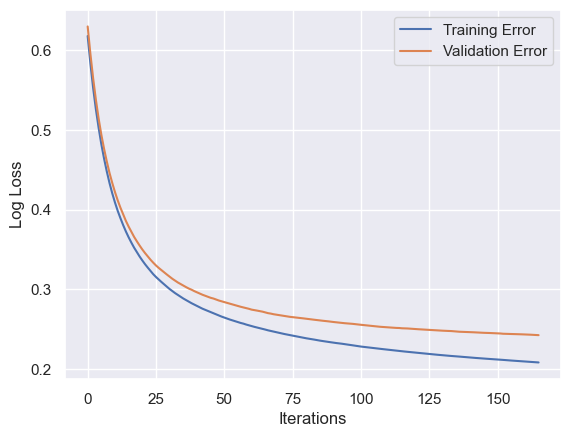

Test ROC-AUC: 0.9644
Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [16341 17734 10239 11875 15274 15472  5769  9420  3791  9973] (showing first 10 indices)
Max index: 18822, Min index: 4
Fitting new base model with 5647 samples
Predictions from new base model before gamma adjustment: [ 0.27441181  0.27441181  0.27441181 -0.33577794 -0.33577794]
New base model fitted - Gamma: 0.992446674600509
Predictions from new base model after gamma adjustment: [ 0.27233909  0.27233909  0.27233909 -0.3332417  -0.3332417 ]
Iteration 0 - Gamma: 0.992446674600509
Iteration 0 - New model predictions: [ 0.02723391  0.02723391  0.02723391 -0.03332417 -0.03332417]
Iteration 0 - Updated predictions: [0.28113262 0.28113262 0.28113262 0.3416907  0.3416907 ]
Iteration 0 - Train Error: 0.648

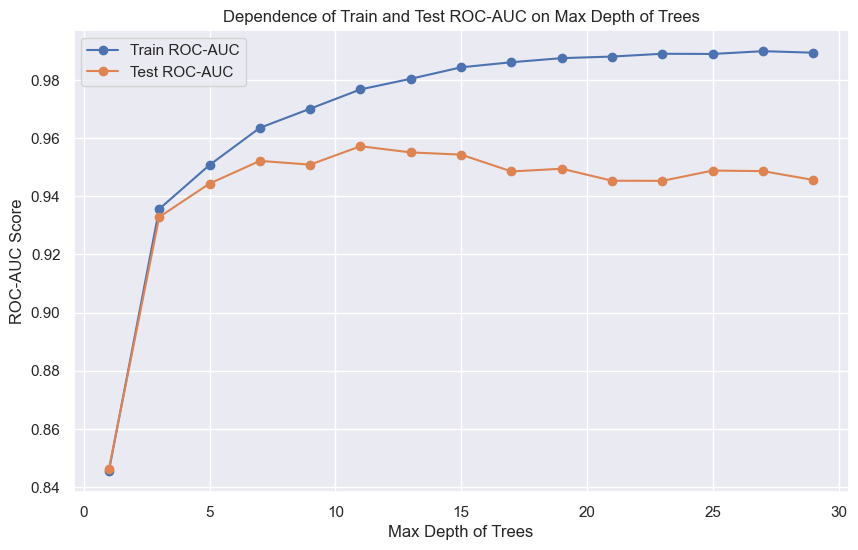

In [90]:
import optuna
from sklearn.metrics import roc_auc_score

# Проверка размеров данных
print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_valid.shape: {x_valid.shape}, y_valid.shape: {y_valid.shape}")

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 9)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    
    boosting_model = Boosting(
        base_model_params={'max_depth': max_depth},
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        plot=False
    )
    
    print(f"Training with max_depth={max_depth}, learning_rate={learning_rate}, subsample={subsample}, n_estimators={n_estimators}")
    
    boosting_model.fit(x_train, y_train)
    
    y_pred = boosting_model.predict_proba(x_valid)[:, 1]
    
    print(f'roc_auc valid: {roc_auc_score(y_valid, y_pred)}')
    
    return roc_auc_score(y_valid, y_pred)

# Создание объекта Optuna для поиска гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Вывод лучших гиперпараметров
print("Best hyperparameters: ", study.best_params)

# Переобучение модели с лучшими гиперпараметрами на тренировочных данных
best_params = study.best_params
best_model = Boosting(
    base_model_params={'max_depth': best_params['max_depth']},
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    plot=True
)

best_model.fit(x_train, y_train, x_valid, y_valid)

# Оценка модели на тестовой выборке
y_test_pred = best_model.predict_proba(x_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Построение графика
train_roc_auc_scores = []
test_roc_auc_scores = []
depth_range = range(1, 31, 2)

for max_depth in depth_range:
    model = Boosting(base_model_params={'max_depth': max_depth})
    model.fit(x_train, y_train)
    train_roc_auc = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    train_roc_auc_scores.append(train_roc_auc)
    test_roc_auc_scores.append(test_roc_auc)

plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_roc_auc_scores, label='Train ROC-AUC', marker='o')
plt.plot(depth_range, test_roc_auc_scores, label='Test ROC-AUC', marker='o')
plt.xlabel('Max Depth of Trees')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.title('Dependence of Train and Test ROC-AUC on Max Depth of Trees')
plt.show()

In [91]:
print("Best hyperparameters: ", study.best_params)
test_roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Best hyperparameters:  {'max_depth': 5, 'learning_rate': 0.29093819957036254, 'subsample': 0.8430338853447417, 'n_estimators': 166}
Test ROC-AUC: 0.9644


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [ 8237 14049 14805 11056 17765 18802   713  2672   992  2425] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 15870 samples
Predictions from new base model before gamma adjustment: [ 0.49438194  0.18678062 -0.13842578  0.28071185 -0.20129128]
New base model fitted - Gamma: 1.0010544873301253
Predictions from new base model after gamma adjustment: [ 0.49490326  0.18697758 -0.13857175  0.28100786 -0.20150354]
Iteration 0 - Gamma: 1.0010544873301253
Iteration 0 - New model predictions: [ 0.14398626  0.05439892 -0.04031581  0.08175592 -0.05862508]
Iteration 0 - Updated predictions: [0.16438027 0.25396761 0.34868235 0.22661061 0.36699161]
Iteration 0 - Train Error: 0.6173379719095491
Iter

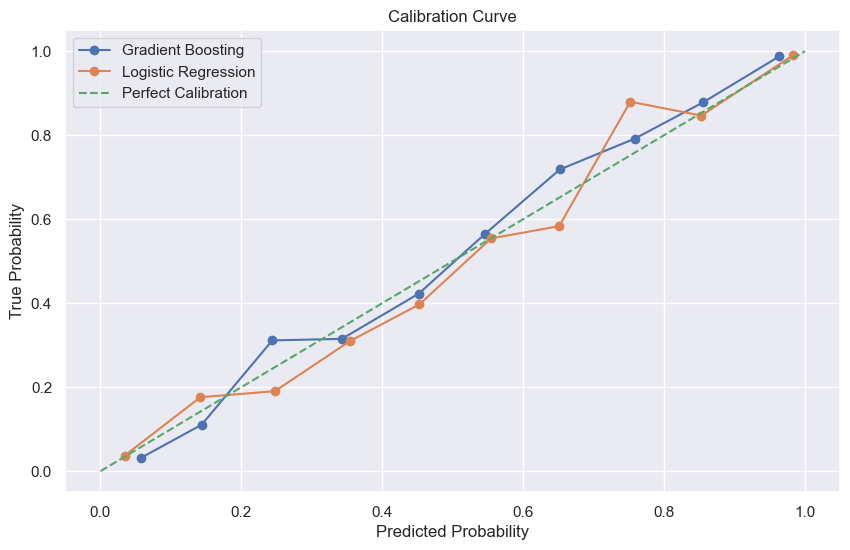

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

# Используем лучшие гиперпараметры для обучения модели бустинга
best_model = Boosting(
    base_model_params={'max_depth': best_params['max_depth']},
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    plot=False
)

# Обучение модели на тренировочных данных
best_model.fit(x_train, y_train, x_valid, y_valid)

# Предсказание вероятностей на тестовых данных
y_test_pred_proba = best_model.predict_proba(x_test)[:, 1]

# Построение калибровочной кривой для модели градиентного бустинга
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=10)

# Обучение логистической регрессии и предсказание вероятностей на тестовых данных
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)
y_test_log_pred_proba = log_reg.predict_proba(x_test)[:, 1]

# Построение калибровочной кривой для логистической регрессии
prob_true_log, prob_pred_log = calibration_curve(y_test, y_test_log_pred_proba, n_bins=10)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Gradient Boosting')
plt.plot(prob_pred_log, prob_true_log, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

Обе модели показывают хорошую калибровку и способность точно оценивать вероятности.
Учитывая эти выводы, можно пользоваться сильными стораннами каждой из моделей, на их сильных диапазонах. Ну или использовать ансамболь моделей.

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [ 8142 13626 12706  6362 18439 13219 18813 12650  1695 11796] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 15870 samples
Predictions from new base model before gamma adjustment: [ 0.51218794  0.07469866  0.07469866  0.26069703 -0.19842125]
New base model fitted - Gamma: 0.9970314029279012
Predictions from new base model after gamma adjustment: [ 0.51066746  0.07447691  0.07447691  0.25992312 -0.19783222]
Iteration 0 - Gamma: 0.9970314029279012
Iteration 0 - New model predictions: [ 0.14857267  0.02166818  0.02166818  0.07562157 -0.05755695]
Iteration 0 - Updated predictions: [0.15979386 0.28669836 0.28669836 0.23274497 0.36592348]
Iteration 0 - Train Error: 0.6172836475834692
Iter

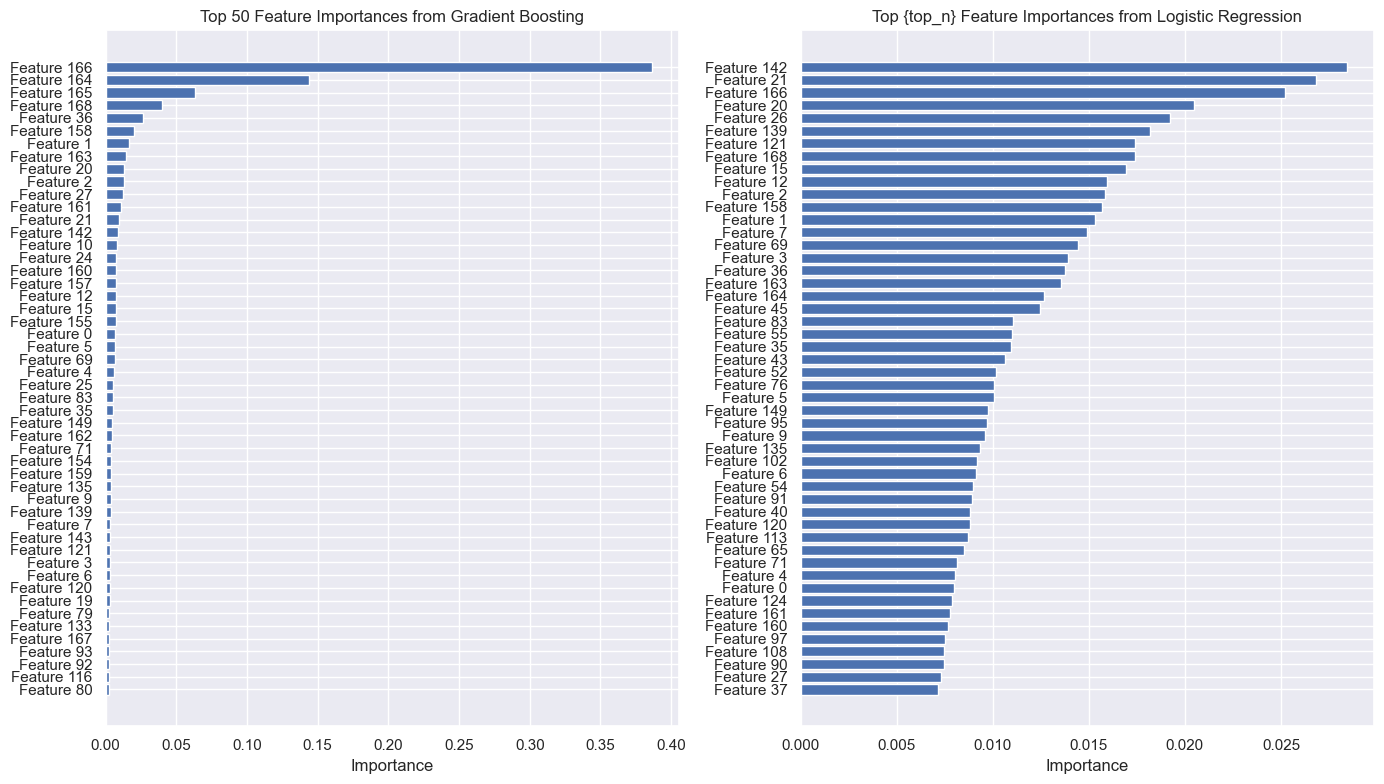

In [93]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Обучение лучшего градиентного бустинга
best_model = Boosting(
    base_model_params={'max_depth': best_params['max_depth']},
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    plot=False
)
best_model.fit(x_train, y_train, x_valid, y_valid)

# Обучение логистической регрессии
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

boosting_importances = best_model.feature_importances_
log_reg_importances = np.abs(log_reg.coef_[0])

# Нормализация важностей
boosting_importances /= np.sum(boosting_importances)
log_reg_importances /= np.sum(log_reg_importances)

# Построение графиков
feature_names = [f'Feature {i}' for i in range(x_train.shape[1])]

# Ранжирование и отбор топ 15 признаков
top_n = 50

boosting_top_indices = np.argsort(boosting_importances)[-top_n:][::-1]
log_reg_top_indices = np.argsort(log_reg_importances)[-top_n:][::-1]

boosting_top_importances = boosting_importances[boosting_top_indices]
log_reg_top_importances = log_reg_importances[log_reg_top_indices]

boosting_top_features = [feature_names[i] for i in boosting_top_indices]
log_reg_top_features = [feature_names[i] for i in log_reg_top_indices]

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.barh(boosting_top_features[::-1], boosting_top_importances[::-1])
plt.title(f'Top {top_n} Feature Importances from Gradient Boosting')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
plt.barh(log_reg_top_features[::-1], log_reg_top_importances[::-1])
plt.title('Top {top_n} Feature Importances from Logistic Regression')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

Model 0 feature importances: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.90882691e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.11024079e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

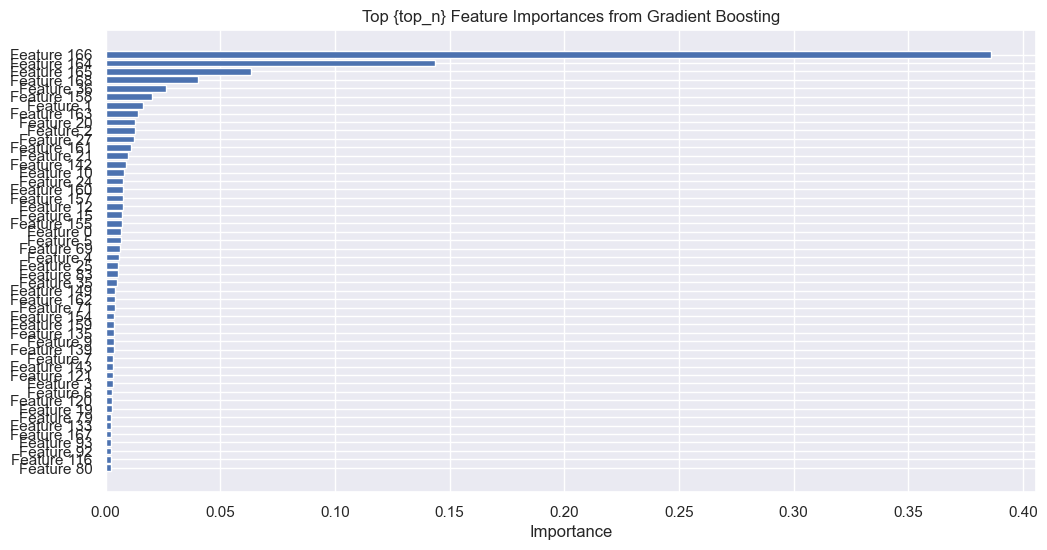

Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [10943  2906  7035  3010  8148 18737 10862  6432   957  1907] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 15870 samples
Predictions from new base model before gamma adjustment: [ 0.51158154  0.34903552 -0.03614508  0.22866041 -0.21876572]
New base model fitted - Gamma: 0.9971338640102423
Predictions from new base model after gamma adjustment: [ 0.51011528  0.34803514 -0.03604148  0.22800504 -0.21813871]
Iteration 0 - Gamma: 0.9971338640102423
Iteration 0 - New model predictions: [ 0.14841202  0.10125672 -0.01048584  0.06633538 -0.06346488]
Iteration 0 - Updated predictions: [0.15995451 0.20710982 0.31885238 0.24203116 0.37183142]
Iteration 0 - Train Error: 0.6177088206768506
Iter

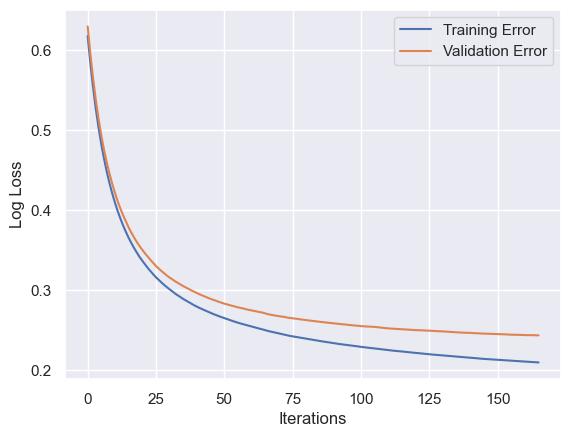

Test ROC-AUC with top 50 features: 0.9647


In [94]:
# Получение важностей признаков из модели градиентного бустинга
boosting_importances = best_model.feature_importances_

# Нормализация важностей
boosting_importances /= np.sum(boosting_importances)

# Отбор топ 15 признаков
top_indices = np.argsort(boosting_importances)[-top_n:][::-1]
top_importances = boosting_importances[top_indices]
top_features = [f'Feature {i}' for i in top_indices]

# Построение графика
plt.figure(figsize=(12, 6))
plt.barh(top_features, top_importances)
plt.title('Top {top_n} Feature Importances from Gradient Boosting')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  # Инвертируем ось Y, чтобы самые важные признаки были сверху
plt.show()

# Отбор топ-15 признаков из данных
x_train_top = x_train[:, top_indices]
x_valid_top = x_valid[:, top_indices]
x_test_top = x_test[:, top_indices]

# Переобучение модели с топ-15 признаками
best_model_top = Boosting(
    base_model_params={'max_depth': best_params['max_depth']},
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    plot=True
)

best_model_top.fit(x_train_top, y_train, x_valid_top, y_valid)

# Оценка модели на тестовой выборке
y_test_pred_top = best_model_top15.predict_proba(x_test_top)[:, 1]
test_roc_auc_top = roc_auc_score(y_test, y_test_pred_top15)

print(f"Test ROC-AUC with top {top_n} features: {test_roc_auc_top:.4f}")

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [95]:
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score

# Обучение логистической регрессии
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Обучение градиентного бустинга
best_model = Boosting(
    base_model_params={'max_depth': best_params['max_depth']},
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    plot=False
)
best_model.fit(x_train, y_train, x_valid, y_valid)

# Получение вероятностей от каждой модели на валидационной выборке
y_proba_log_reg_valid = log_reg.predict_proba(x_valid)[:, 1]
y_proba_boosting_valid = best_model.predict_proba(x_valid)[:, 1]

# Определение функции для минимизации
def weighted_roc_auc(weights):
    y_proba_ensemble = (weights[0] * y_proba_log_reg_valid + weights[1] * y_proba_boosting_valid)
    return -roc_auc_score(y_valid, y_proba_ensemble)

# Начальные значения весов
initial_weights = [0.1, 0.1]

# Ограничения на веса (должны быть в пределах от 0 до 1)
bounds = [(0, 1), (0, 1)]

# Ограничение, что сумма весов должна быть равна 1
constraints = {'type': 'eq', 'fun': lambda weights: 1 - sum(weights)}

# Оптимизация весов
result = minimize(weighted_roc_auc, initial_weights, bounds=bounds, constraints=constraints,  options={'maxiter': 10000})
optimal_weights = result.x

print(f'Optimal Weights: {optimal_weights}')

# Получение вероятностей от каждой модели на тестовой выборке
y_proba_log_reg_test = log_reg.predict_proba(x_test)[:, 1]
y_proba_boosting_test = best_model.predict_proba(x_test)[:, 1]

# Применение оптимальных весов к тестовой выборке
y_proba_ensemble_optimal = (optimal_weights[0] * y_proba_log_reg_test + optimal_weights[1] * y_proba_boosting_test)

# Оценка ансамбля с оптимальными весами
ensemble_roc_auc_optimal = roc_auc_score(y_test, y_proba_ensemble_optimal)
print(f'Ensemble Test ROC-AUC with Optimal Weights: {ensemble_roc_auc_optimal:.4f}')

Initial prediction (mean): 0.3083665338645418
Iteration 0 - Residuals: [ 0.5764865 -0.4235135 -0.4235135  0.5764865 -0.4235135]
Iteration 0 - Predictions before update: [0.30836653 0.30836653 0.30836653 0.30836653 0.30836653]
Number of samples: 18825
Generated indices: [  806   880 17902 16569 11024  3086 11511  3598 12304   931] (showing first 10 indices)
Max index: 18824, Min index: 0
Fitting new base model with 15870 samples
Predictions from new base model before gamma adjustment: [ 0.50033558  0.17432934 -0.13054475  0.2964865  -0.21846149]
New base model fitted - Gamma: 0.9965790583562283
Predictions from new base model after gamma adjustment: [ 0.49862396  0.17373297 -0.13009816  0.29547224 -0.21771415]
Iteration 0 - Gamma: 0.9965790583562283
Iteration 0 - New model predictions: [ 0.14506876  0.05054556 -0.03785053  0.08596416 -0.06334136]
Iteration 0 - Updated predictions: [0.16329778 0.25782098 0.34621706 0.22240237 0.3717079 ]
Iteration 0 - Train Error: 0.6173940535451348
Iter

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [96]:
# Импорт необходимых библиотек

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score


# Создание модели CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

# Обучение модели
model.fit(
    x_train, y_train,
    eval_set=(x_valid, y_valid),
    early_stopping_rounds=50
)

# Предсказание на тестовой выборке
y_pred_prob = model.predict_proba(x_test)[:, 1]

# Оценка ROC AUC на тестовой выборке
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC: {roc_auc:.2f}')

0:	test: 0.9224845	best: 0.9224845 (0)	total: 9.41ms	remaining: 9.4s
100:	test: 0.9668287	best: 0.9668287 (100)	total: 745ms	remaining: 6.63s
200:	test: 0.9680896	best: 0.9682002 (191)	total: 1.5s	remaining: 5.98s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9682795145
bestIteration = 214

Shrink model to first 215 iterations.
ROC AUC: 0.97


Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
